## Imports

In [171]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Audio Dataset

In [172]:
def generate_noisy_random_walk(n_steps, min_val, max_val, step_range):
    """
    Generate a noisy random walk.
    :param n_steps: Number of steps in the random walk.
    :param min_val: Minimum value for the random walk.
    :param max_val: Maximum value for the random walk.
    :param step_range: Range of step sizes (tuple of min and max step size).
    :return: Array representing the random walk.
    """
    random_walk = np.zeros(n_steps)
    random_walk[0] = np.random.uniform(min_val, max_val)
    for i in range(1, n_steps):
        step = np.random.choice([-1, 1]) * np.random.uniform(*step_range)
        random_walk[i] = np.clip(random_walk[i-1] + step, min_val, max_val)
    return random_walk

def generate_waveform(length, fs, freq_range, amp_range, freq_step_range, amp_step_range):
    """
    Generate a waveform from noisy random walks for frequency and amplitude.
    :param length: Length of the waveform in samples.
    :param fs: Sampling frequency.
    :param freq_range: Tuple of min and max frequency.
    :param amp_range: Tuple of min and max amplitude.
    :param freq_step_range: Step range for frequency random walk.
    :param amp_step_range: Step range for amplitude random walk.
    :return: Generated waveform.
    """
    n_freq_steps = int(length / (0.05 * fs))  # Based on max duration of 50ms per frequency step
    n_amp_steps = n_freq_steps  # Same number of steps for amplitude for simplicity

    # Generate noisy random walks for frequency and amplitude
    frequencies = generate_noisy_random_walk(n_freq_steps, *freq_range, freq_step_range)
    amplitudes = generate_noisy_random_walk(n_amp_steps, *amp_range, amp_step_range)

    # Interpolate over the waveform length
    interpolated_frequencies = np.interp(np.arange(length), 
                                         np.linspace(0, length, n_freq_steps, endpoint=False), 
                                         frequencies)
    interpolated_amplitudes = np.interp(np.arange(length), 
                                        np.linspace(0, length, n_amp_steps, endpoint=False), 
                                        amplitudes)

    # Generate the waveform
    waveform = interpolated_amplitudes * np.sin(2 * np.pi * interpolated_frequencies * np.arange(length) / fs)
    return waveform

def prepare_data(waveform, n_samples):
    """
    Chop the waveform into N equal-length samples.
    :param waveform: Input waveform.
    :param n_samples: Number of samples to divide the waveform into.
    :return: List of samples.
    """
    sample_length = len(waveform) // n_samples
    data = np.array([waveform[i:i + sample_length] for i in range(0, len(waveform), sample_length)])
    data = np.reshape(data, (data.shape[0], data.shape[1], 1))
    return data

In [269]:
# Example usage
fs = 1000  # Sampling frequency
T = fs * 10000  # Total length of the waveform (e.g., 10 seconds)
N = 10000  # Number of samples to chop into

# Generate waveform
waveform = generate_waveform(T, fs, freq_range=(100, 200), amp_range=(0.2, 1.0), 
                             freq_step_range=(1, 2), amp_step_range=(0.05, 0.1))

# Chop into samples
data = prepare_data(waveform, N)

# Print information about the generated samples
print(f"Generated {len(data)} samples, each of length {len(data[0])} samples.")

Generated 10000 samples, each of length 1000 samples.


In [270]:
data.shape

(10000, 1000, 1)

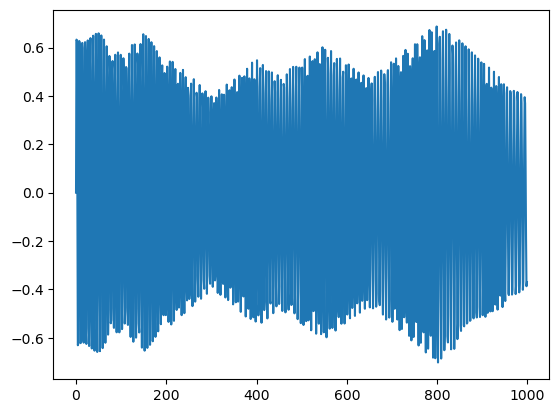

In [311]:
plt.plot(data[0])

### Data Loader

In [275]:
def create_dataloader(data, batch_size=256, reshuffle_after_epoch=True):
    '''
    Creates a DataLoader for Pytorch to train the autoencoder with the image data converted to a tensor.

    Args:
        dataset (4D numpy array): image dataset with shape (n_samples, n_channels, n_pixels_height, n_pixels_width).
        batch_size (int; default=32): the size of the batch updates for the autoencoder training.

    Returns:
        DataLoader (Pytorch DataLoader): dataloader that is ready to be used for training an autoencoder.
    '''
    if data.shape[-1] == 1:
        data = np.transpose(data, (0,2,1))
    tensor_dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(data).float())
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=reshuffle_after_epoch)

In [423]:
dataset = create_dataloader(data, batch_size=256, reshuffle_after_epoch=True)

## Autoencoder

In [424]:
class ConvAE(nn.Module):
    def __init__(self, n_hidden=100, sample_length=1000, kernel_size=20):
        super().__init__()

        self.n_hidden = n_hidden
        self.kernel_size=kernel_size

        # Encoder
        self.conv1 = nn.Conv1d(1, 16, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2, padding=1)
        
        # Hidden layer
        self.flattened_size = self.calculate_flattened_size(sample_length, kernel_size)
        self.fc1 = nn.Linear(64 * self.flattened_size, n_hidden)

        # Decoder
        self.fc2 = nn.Linear(n_hidden, 64 * self.flattened_size)
        self.conv4 = nn.ConvTranspose1d(64, 32, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)
        self.conv5 = nn.ConvTranspose1d(32, 16, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)
        self.conv6 = nn.ConvTranspose1d(16, 1, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)

    def calculate_flattened_size(self, sample_length, kernel_size):
        size_after_conv1 = (sample_length - kernel_size + 2 * 1) // 2 + 1
        size_after_conv2 = (size_after_conv1 - kernel_size + 2 * 1) // 2 + 1
        size_after_conv3 = (size_after_conv2 - kernel_size + 2 * 1) // 2 + 1
        return size_after_conv3

    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * self.flattened_size)
        x = F.relu(self.fc1(x))
        return x

    def decoder(self, x):
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, self.flattened_size)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.tanh(self.conv6(x))
        return x

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

    def backward(self, optimizer, criterion, x, y_true, alpha=0):
        optimizer.zero_grad()
        y_pred, hidden = self.forward(x)
        recon_loss = criterion(y_pred, y_true)

        whitening_loss = 0
        batch_size, hidden_dim = hidden.shape
        if alpha != 0:
            C = torch.eye(hidden_dim, device='cuda') - torch.mm(hidden.t(), hidden)
            whitening_loss = alpha * torch.norm(C) / (batch_size*hidden_dim)
        
        loss = recon_loss + whitening_loss
        loss.backward()
        optimizer.step()
        
        return recon_loss.item()

In [426]:
# Create an instance of the autoencoder
model = ConvAE(n_hidden=300, sample_length=data.shape[1], kernel_size=20)

### Train

In [427]:
def train_autoencoder(model, train_loader, num_epochs=1000, learning_rate=1e-3, alpha=0):
    """
    Train the autoencoder model.
    :param model: Autoencoder model.
    :param dataloader: DataLoader for the training data.
    :param epochs: Number of training epochs.
    :param learning_rate: Learning rate for the optimizer.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to('cuda')
    history = []
    for epoch in range(num_epochs):
        running_loss = 0
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                inputs = inputs.to('cuda')

                loss = model.backward(optimizer=optimizer, criterion=criterion, x=inputs, y_true=inputs, alpha=alpha)
                running_loss += loss

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

        history.append(running_loss/len(train_loader))
        
    return history

In [428]:
history = train_autoencoder(model, dataset, num_epochs=2000, learning_rate=1e-3, alpha=0)

Epoch 64/2000, Loss: 0.0616: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.26it/s]


Epoch 128/2000, Loss: 0.0488: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.58it/s]


Epoch 192/2000, Loss: 0.0428: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.10it/s]


Epoch 256/2000, Loss: 0.0399: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 61.94it/s]


Epoch 320/2000, Loss: 0.0370: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.91it/s]


Epoch 384/2000, Loss: 0.0367: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.18it/s]


Epoch 448/2000, Loss: 0.0351: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.32it/s]


Epoch 512/2000, Loss: 0.0344: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.99it/s]


Epoch 576/2000, Loss: 0.0333: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.98it/s]


Epoch 640/2000, Loss: 0.0328: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.91it/s]


Epoch 704/2000, Loss: 0.0317: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.80it/s]


Epoch 768/2000, Loss: 0.0324: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.99it/s]


Epoch 832/2000, Loss: 0.0312: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.87it/s]


Epoch 896/2000, Loss: 0.0310: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.23it/s]


Epoch 960/2000, Loss: 0.0308: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.86it/s]


Epoch 1024/2000, Loss: 0.0309: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.93it/s]


Epoch 1088/2000, Loss: 0.0304: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.26it/s]


Epoch 1152/2000, Loss: 0.0306: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.87it/s]


Epoch 1216/2000, Loss: 0.0302: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.10it/s]


Epoch 1280/2000, Loss: 0.0296: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.51it/s]


Epoch 1344/2000, Loss: 0.0303: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.86it/s]


Epoch 1408/2000, Loss: 0.0310: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.67it/s]


Epoch 1472/2000, Loss: 0.0287: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.14it/s]


Epoch 1536/2000, Loss: 0.0289: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.58it/s]


Epoch 1600/2000, Loss: 0.0286: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.12it/s]


Epoch 1664/2000, Loss: 0.0282: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.41it/s]


Epoch 1728/2000, Loss: 0.0283: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.87it/s]


Epoch 1792/2000, Loss: 0.0292: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.58it/s]


Epoch 1856/2000, Loss: 0.0279: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.24it/s]


Epoch 1920/2000, Loss: 0.0276: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.03it/s]


Epoch 1984/2000, Loss: 0.0278: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.97it/s]


Epoch 2000/2000, Loss: 0.0272: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.45it/s]


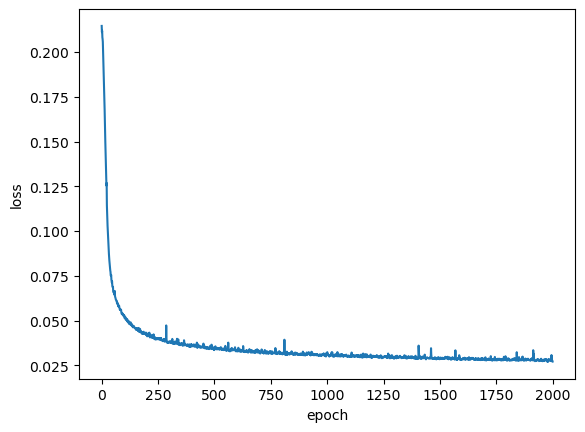

In [429]:
plt.plot(history)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [430]:
def predict(sample, model):
    '''
    Returns the output of model(image), and reshapes it to be compatible with plotting funtions such as plt.imshow().

    Args:
        sample (3D numpy array): sample with shape (n_channels, n_timepoints).
        model (Pytorch Module): convolutional autoencoder that is prepared to process images such as 'image'.

    Returns:
        output_sample (3D numpy array): output timeseries with shape (n_timepoints, n_channels)
    '''
    if sample.shape[-1] <= 4:
        sample = np.transpose(sample, (1,0))
    n_channels, n_timepoints = sample.shape
    sample = np.reshape(sample, (1, n_channels, n_timepoints))
    sample = torch.from_numpy(sample).float().to(next(model.parameters()).device)
    output_sample = model(sample)[0].detach().cpu().numpy()
    output_sample = np.reshape(output_sample, (n_channels, n_timepoints))
    output_sample = np.transpose(output_sample, (1,0))
    return output_sample

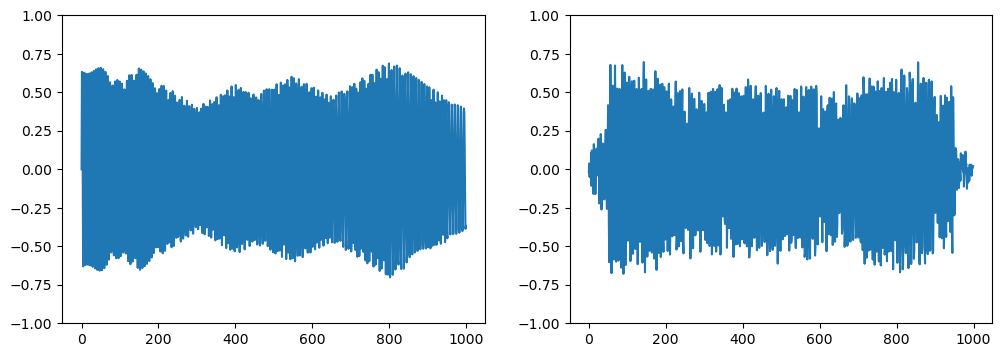

In [431]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(data[0])
plt.ylim(-1,1)

plt.subplot(122)
plt.plot(predict(data[0], model))
plt.ylim(-1,1)

plt.show()

## Frequency receptive field analysis

In [440]:
def create_test_dataset(freq_range, delta_freq, sample_length):
    """
    Build a test dataset with samples at different frequencies.
    Args:
        min_freq (float): Minimum frequency.
        max_freq (float): Maximum frequency.
        delta_freq (float): Frequency resolution.
        sample_length (int): Length of each sample.
    Returns:
        torch.Tensor: Test dataset.
    """
    frequencies = np.arange(freq_range[0], freq_range[1], delta_freq)
    test_dataset = []
    for freq in frequencies:
        t = np.linspace(0, 1, sample_length, endpoint=False)
        sample = np.sin(2 * np.pi * freq * t)
        test_dataset.append(sample)
    test_dataset = np.reshape(test_dataset, (len(test_dataset), len(test_dataset[0]), 1))
    return test_dataset

In [441]:
def get_latent_vectors(dataset, model, batch_size=256):
    '''
    Returns the latent activation vectors of the autoencoder model after passing all the images in the dataset.

    Args:
        dataset (numpy array): image dataset with shape 
        model (Pytorch Module): convolutional autoencoder that is prepared to process the images in dataset.

    Returns:
        latent_vectors (2D numpy array): latent activation vectors, matrix with shape (n_samples, n_hidden), where n_hidden is the number of units in the hidden layer.
    '''
    if dataset.shape[-1] == 1:
        dataset = np.transpose(dataset, (0,2,1))
    tensor_dataset = TensorDataset(torch.from_numpy(dataset).float(), torch.from_numpy(dataset).float())
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, _ = batch
            latent = model(inputs.to('cuda'))[1]
            latent_vectors.append(latent.cpu().numpy())
    latent_vectors = np.concatenate(latent_vectors)
    return latent_vectors

In [442]:
test_dataset = create_test_dataset(freq_range=(100, 200), delta_freq=0.1, sample_length=data.shape[1])

In [443]:
hidden_activations = get_latent_vectors(test_dataset, model)

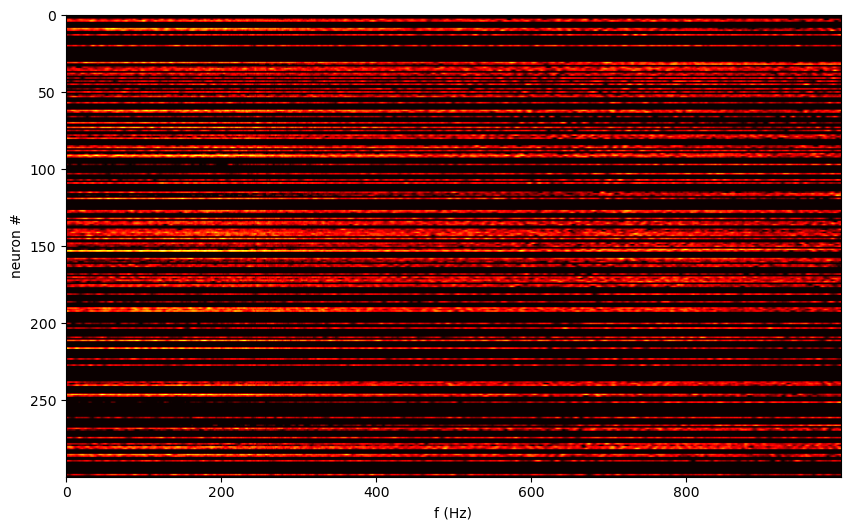

In [444]:
plt.figure(figsize=(10,6))

plt.imshow(hidden_activations.T, aspect='auto', cmap='hot', origin='upper')
plt.xlabel('f (Hz)')
plt.ylabel('neuron #')
plt.show()

In [445]:
def normalize_and_reorder(arr):
    """
    This function takes a 2D numpy array and performs two operations:
    1. Normalizes each row of the array based on its maximum value.
    2. Reorders the rows based on the index of the peak (maximum) value in each row.

    Parameters:
    arr (numpy.ndarray): The input 2D numpy array.

    Returns:
    numpy.ndarray: The processed 2D numpy array.
    """
    # Normalize each row by its maximum value
    row_maxes = np.max(arr, axis=1).reshape(-1, 1)
    normalized_arr = arr / row_maxes

    # Find the index of the maximum value in each row
    peak_indices = np.argmax(normalized_arr, axis=1)

    # Reorder the rows based on the peak indices
    sorted_indices = np.argsort(peak_indices)
    reordered_arr = normalized_arr[sorted_indices]

    return reordered_arr

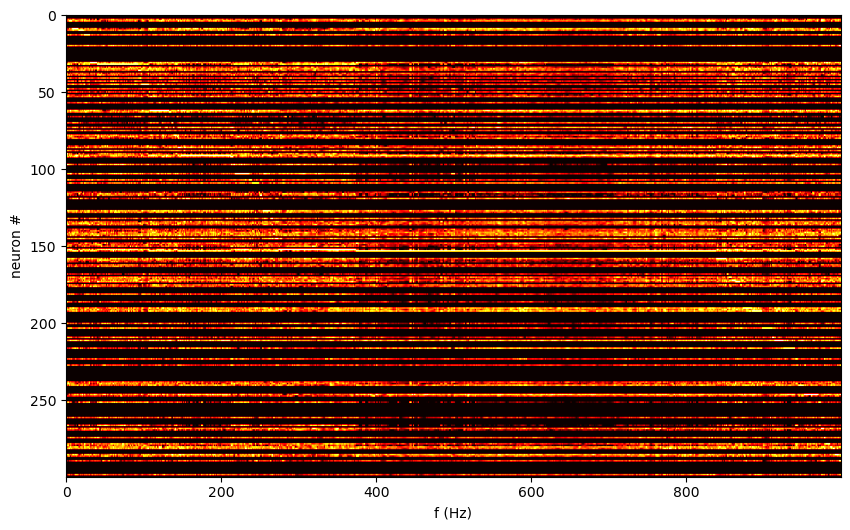

In [446]:
plt.figure(figsize=(10,6))

plt.imshow(normalize_and_reorder(hidden_activations).T, aspect='auto', cmap='hot', origin='upper')
plt.xlabel('f (Hz)')
plt.ylabel('neuron #')
plt.show()